# Project: Providing data-driven suggestions for HR
# Google Advanced Data Analytics Capstone
## By: Abdullah El-Gohary
---
## Table of Contents:

1. [Introduction](#'1')
2. [Data Loading and Preparation](#'2')
3. [Exploratory Data Analysis](#cell-id)
4. Model Selection
5. Model Construction</a></li>
6. Confirm Model Assumptions</a></li>
7. Summary of model results</a></li>
8. Summary of model results</a></li>
9. Conclusion, Recommendations, Next Steps</a></li>   






<a name="'1'"></a>
# Introduction

### About the Company
Salifort Motors is a ***fictional*** French-based manufacturer specializing in alternative energy vehicles. With a global workforce of over 100,000 employees, the company is engaged in the research, design, construction, validation, and distribution of electric, solar, algae, and hydrogen-based vehicles.

### The Business Case
The senior leadership team at Salifort Motors has assigned us the task of analyzing data to generate strategies for enhancing employee retention. As part of this initiative, they are interested in developing a model that can predict whether an employee is likely to leave the company. The primary question posed by the HR department at Salifort Motors is: What factors are likely to influence an employee's decision to leave the company?

### The Goal of this Project
**The objective of this project is to analyze the data collected by the HR department and build a predictive model that can determine if an employee is likely to leave the company.**

By predicting which employees are likely to quit, we may be able to identify contributing factors to their departure. Given that finding, interviewing, and hiring new employees is both time-consuming and costly, enhancing employee retention will be advantageous for the company.

<a name="'2'"></a>
# Data Loading and Preparation

## Data Dictionary


Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

## Import packages and Load the dataset

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # to display all columns

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Model selection and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor, plot_importance

# Saving Models
import pickle

### Load the Dataset

In [2]:
# Raw GitHub link to data
url = 'https://raw.githubusercontent.com/a-elgohary/hr_project/main/hr_data.csv'

# Load the dataset into a DataFrame
df_original = pd.read_csv(url)

# Create a copy for data manipulation
df = df_original.copy()

# Display the first rows of 'df'
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data cleaning and preprocessing

In [3]:
# # Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


There are no Missing Values

### Standarizing columns names

In [4]:
# List 'df' columns
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [5]:
# Dict. of columns to be renamed
rename_cols = {'satisfaction_level': 'satisfaction', # made more consice
               'last_evaluation': 'evaluation', # made more consice
               'number_project': 'n_projects', # made more consice
               'average_montly_hours': 'average_monthly_hours', #corrected spelling
               'time_spend_company': 'tenure', # made more consice
               'Work_accident': 'work_accident', # made snake_case
               'promotion_last_5years': 'promotion_5y', # made more consice
               'Department': 'department', # made snake_case
               }

# Renaming columns
df.rename(columns= rename_cols, inplace= True)

# confirming change
df.columns

Index(['satisfaction', 'evaluation', 'n_projects', 'average_monthly_hours',
       'tenure', 'work_accident', 'left', 'promotion_5y', 'department',
       'salary'],
      dtype='object')

### Check for duplicates

In [6]:
# Check for duplicates
df.duplicated().sum()

3008

In [7]:
# Archive duplicates for record-keeping and future reference.
df_duplicates = df[df.duplicated()].copy()

# Drop duplicates
df = df.drop_duplicates(keep = 'first')

# Check for duplicates
df.duplicated().sum()

0

<a name="cell-id"></a>
# Exploratory Data Analysis

## Outlier Detection

We will be constructing a box plot to provide a comprehensive understanding of potential outliers within the data.\
This visualization technique will provide us with a high-level overview of the data distribution.

In [8]:
df.columns

Index(['satisfaction', 'evaluation', 'n_projects', 'average_monthly_hours',
       'tenure', 'work_accident', 'left', 'promotion_5y', 'department',
       'salary'],
      dtype='object')

In [9]:
# Define a list of quantitative columns
quant_cols = ['satisfaction', 'evaluation', 'n_projects',
              'average_monthly_hours', 'tenure'
              ]
# Create a new DataFrame of quantitative columns
df_quant = df[quant_cols]
df_quant.head()

,satisfaction,evaluation,n_projects,average_monthly_hours,tenure
0,0.38,0.53,2,157,3
1,0.80,0.86,5,262,6
2,0.11,0.88,7,272,4
3,0.72,0.87,5,223,5
4,0.37,0.52,2,159,3


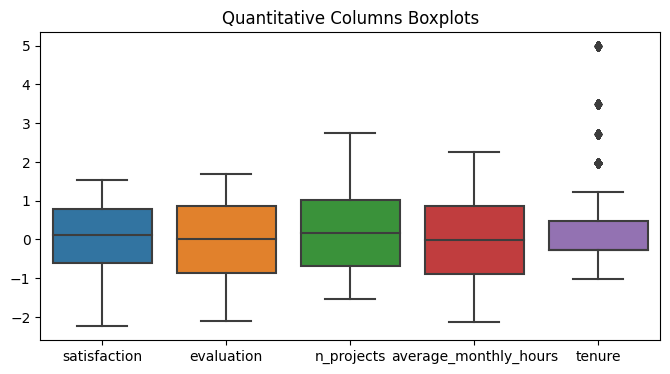

In [10]:
# Create a StandardScaler instance
scaler = StandardScaler()

# fit the scaler to the data and transform it
df_quant_scaled = pd.DataFrame(scaler.fit_transform(df_quant),
                             columns = df_quant.columns)

# Create a boxplot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize = (8,4))

sns.boxplot(data = df_quant_scaled);
plt.title('Quantitative Columns Boxplots');

We observe that ‘tenure’ is the sole column presenting outliers. We’re going to look into this more. But generally, it’s normal for some employees to have worked at the company longer than others. This can explain why we see these outliers.

#### Detecting outliers using interquartile range (IQR) method

In [11]:
def iqr_outliers(df, col, iqr_factor):
    """
    This function returns a new Dataframe that only includes outliers
    using the interquartile range (IQR) method
    ---
    Parameters:
    ---
    df (DataFrame)    : The input Dataframe
    col (str)         : The name of the selected column
    iqr_factor (float): The factor to multiply the IQR by to determine
    the bounds of the outlier
    """
    # Calculate the first (Q1) and third (Q3) quartiles
    lower_quantile = df[col].quantile(0.25)
    upper_quantile = df[col].quantile(0.75)

    # Calculate Interquartile range
    iqr = upper_quantile - lower_quantile

    # Calculate the lower and the upper limit for outliers
    lower_limit = lower_quantile - iqr_factor * iqr
    upper_limit = upper_quantile + iqr_factor * iqr

    outliers = df[(df[col] > upper_limit) | (df[col] < lower_limit)]

    print('Upper Limit: {}'.format(upper_limit))
    print('Lower Limit: {}'.format(lower_limit))
    print('Outliers Count: {}'.format(len(outliers)))
    # Return a DataFrame containing only the outliers
    return outliers

In [12]:
# Check and save the outliers in the 'tenure' column
tenure_outliers = iqr_outliers(df, 'tenure', 1.5)
tenure_outliers.head()

Upper Limit: 5.5
Lower Limit: 1.5
Outliers Count: 824


,satisfaction,evaluation,n_projects,average_monthly_hours,tenure,work_accident,left,promotion_5y,department,salary
1,0.80,0.86,5,262,6,0,1,0,sales,medium
17,0.78,0.99,4,255,6,0,1,0,sales,low
34,0.84,0.87,4,246,6,0,1,0,hr,low
47,0.57,0.70,3,273,6,0,1,0,support,low
67,0.90,0.98,4,264,6,0,1,0,product_mng,medium


We have saved the outliers of the tenure column in the variable ‘tenure_outliers’. We will not take any further actions since we consider it normal for some employees to have worked more years than others.

## Descriptive Statistics

In [13]:
# Gather descriptive statistics about the data
df.describe()

,satisfaction,evaluation,n_projects,average_monthly_hours,tenure,work_accident,left,promotion_5y
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Some insights from the descriptive statistics:

1. **Satisfaction**: The average satisfaction level is approximately 0.63, with a standard deviation of 0.24. This indicates that ***satisfaction levels vary quite a bit*** among your data points. The minimum satisfaction level is 0.09 and the maximum is 1.0, showing a wide range of satisfaction levels.

2. **Evaluation**: The average evaluation score is approximately 0.72, with a standard deviation of 0.17, indicating less variability than the satisfaction scores. However, there is still a considerable amount of variability as the scores do range from 0.36 to 1.0.

3. **Number of Projects**: On average, individuals are handling around 4 projects (3.8 to be precise). The minimum number of projects someone is handling is 2 and the maximum is 7.

4. **Average Monthly Hours**: Individuals work around 200 hours per month on average, with a standard deviation of approximately 49 hours, indicating ***significant variability*** in working hours. The minimum average monthly hours are 96 and the maximum is 310.

5. **Tenure**: The average tenure is approximately 3.36 years, with a standard deviation of about 1.33 years, indicating variability in tenure lengths.

6. **Work Accident**: About 15% of individuals have had a work accident.

7. **Left**: About 16% of individuals have left.

8. **Promotion in Last 5 Years**: Only about 1.7% of individuals received a promotion in the last five years.

## Univariate Analysis


    - Outlier Detection
        - Techniques to detect and handle outliers

    - Univariate Analysis
        - Distribution of individual variables

    - Bivariate Analysis
        - Relationship between pairs of variables

    - Multivariate Analysis
        - Interactions between multiple variables

    - Correlation Analysis
        - Correlation matrix and heatmap

    - Feature Engineering
        - Creating new features from existing ones

    - Conclusion
        - Key insights from the analysis
        - Next steps for further analysis or model building


